In [1]:
import prob_dist as pd
import resfuncRead as rfr


ptres = rfr.getRFunc('data/jardin_ptres.txt')

qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

fp = rfr.makeRFunc(ptres[1]['sqrt'])

fq = rfr.makeRFunc(qres[1]['lin'],True)

sigp = lambda x: fp(x) #convert from eV

sigq = lambda x: fq(x) #convert from eV

f = pd.YEr_v2_2D_fast(sigp,sigq,4,(3.3/1000),125)


print(f(0.25,10,10))


g = pd.YErSpec_v2_2D(f)

print(g(0.06,10))


2.1346631304622536
0.00575704086204366


In [2]:
#make a yield function
import numpy as np

Ertest = 40
y10 = lambda x: g(x,Ertest)
y10v = np.vectorize(y10)

x = np.arange(0,0.6,0.01)
y = y10v(x)

In [3]:
#test out the plotting 
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

0.31080699260650724


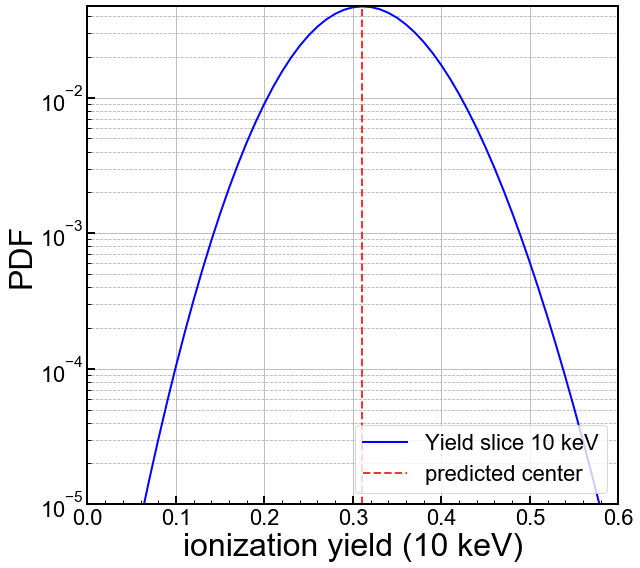

In [4]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ynr = lambda x: 0.16*x**0.18
ymax = np.max(y)

#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, Y_Er_v(x,Ertest),label='E$_r$ function')
ax1.plot(x, y,color='b',lw=2, label='Yield slice 10 keV')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
#ax1.contour(Xnr, Ynr, Znr, 50,cmap='RdGy');
#plt.contourf(Xnr, Ynr, Znr, 50,cmap='RdGy');

print(ynr(Ertest))
ax1.axvline(ynr(Ertest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted center')

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(0, 0.6) 
ax1.set_ylim(1e-5,ymax)
ax1.set_xlabel('ionization yield (10 keV)',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
#plt.colorbar()
plt.show()

In [5]:
import time

start = time.time()
f(0.25,40,40)
end = time.time()
print(end - start)

start = time.time()
g(0.07,10)
end = time.time()
print(end - start)

0.00025534629821777344
0.007276058197021484


In [6]:
#make a function for minimizing 
from scipy.integrate import quad

norm = lambda Er: quad(g,-0.1,1,limit=100,args=(Er,))[0]
inty = lambda a,Er: quad(g,ynr(Er)-a,ynr(Er)+a,limit=100,args=(Er,))[0]/norm(Er)
#inty = lambda a,Er: quad(g,ynr(Er)-a,ynr(Er)+a,args=(Er,))[0]

print(norm(40))
start = time.time()
print(inty(0.0627,40))
end = time.time()
print(end - start)

0.007336958043001721
0.6867783999381208
1.0140726566314697


In [7]:
V=4
eps=3.3/1000
F=100
Eqbar = lambda Er: ynr(Er)*Er
Et = lambda Er: (1+(V/(eps*1000))*ynr(Er))*Er
Ensig = lambda Er: np.sqrt(F*Eqbar(Er)/eps)

Cexp = lambda Y,Etr,Er: -(Etr-Er)**2/(2*sigp(Et(Er))**2) -((ynr(Er)*Er/eps)-(Y*Etr/eps))**2/(2*Ensig(Er)**2)

a = lambda Y,Etr,Er: (2*(V/(1000*eps))*(Etr-Er))/(2*sigp(Et(Er)))+(2*(ynr(Er)*Er-Y*Etr))/(2*eps**2*Ensig(Er)**2)

b = lambda Y,Etr,Er: ((V/(1000*eps))**2/(2*sigp(Et(Er))**2) + 1/(2*sigq(Eqbar(Er))**2) + 1/(2*eps**2*Ensig(Er)**2))

ABexp = lambda Y,Etr,Er: a(Y,Etr,Er)**2/(4*b(Y,Etr,Er))

print(Cexp(0.001,40,40))
print(ABexp(0.5,40,40))

-18.715770305293134
0.3516659459970309


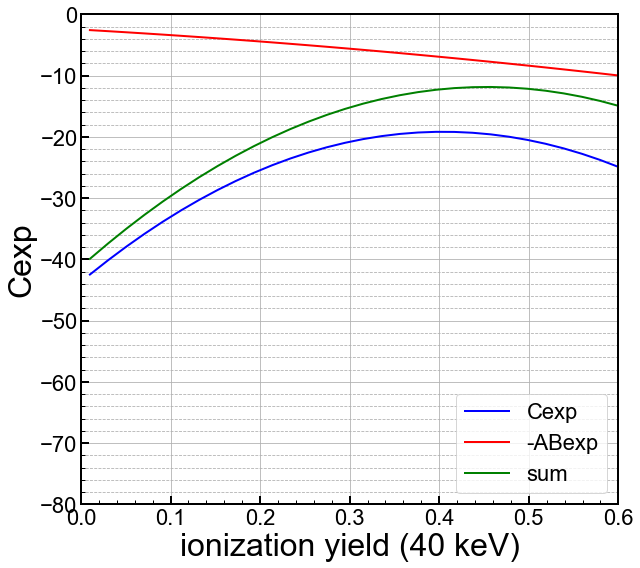

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

Etest=40
Ertest=50
x = np.linspace(0.01,0.6,30)
Cexpv = np.vectorize(Cexp)
ABexpv = np.vectorize(ABexp)

#print(Cexpv(x,40,40))

#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, Y_Er_v(x,Ertest),label='E$_r$ function')
ax1.plot(x, Cexpv(x,Etest,Ertest),color='b',lw=2, label='Cexp')
ax1.plot(x, -ABexpv(x,Etest,Ertest),color='r',lw=2, label='-ABexp')
ax1.plot(x, Cexpv(x,Etest,Ertest)+ABexpv(x,Etest,Ertest),color='g',lw=2, label='sum')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
#ax1.contour(Xnr, Ynr, Znr, 50,cmap='RdGy');
#plt.contourf(Xnr, Ynr, Znr, 50,cmap='RdGy');

#ax1.axvline(ynr(Ertest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted center')

ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0, 0.6) 
ax1.set_ylim(-80,0)
ax1.set_xlabel('ionization yield ({} keV)'.format(Etest),**axis_font)
ax1.set_ylabel('Cexp',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
#plt.colorbar()
plt.show()

10.0


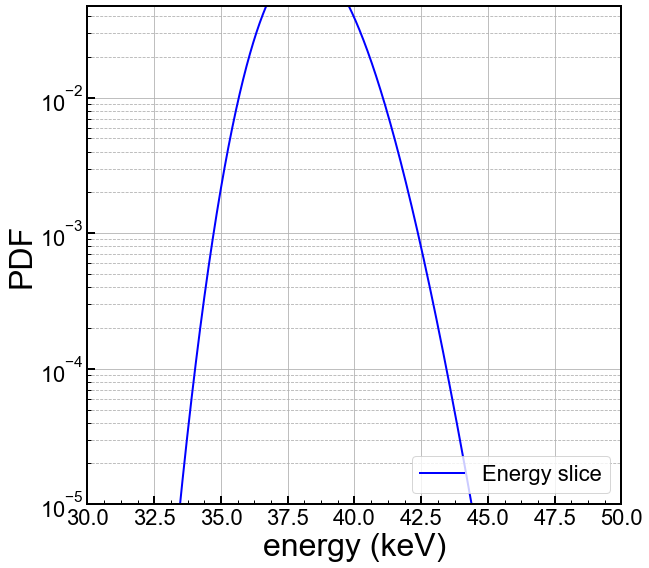

In [9]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

Ec = 40

m = (10-3.0)/(40-10)
b = 3-m*10
width = lambda Etr: m*Etr + b
print(width(40))
fa = pd.YEr_v2_2D_fast(sigp,sigq,4,(3.3/1000),50)

e = np.arange(Ec-width(Ec),Ec+width(Ec),0.01)
fv = np.vectorize(fa)

#print(f(0.2,10,10))

#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, Y_Er_v(x,Ertest),label='E$_r$ function')
ax1.plot(e, fv(0.2,Ec,e),color='b',lw=2, label='Energy slice')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
#ax1.contour(Xnr, Ynr, Znr, 50,cmap='RdGy');
#plt.contourf(Xnr, Ynr, Znr, 50,cmap='RdGy');



ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(Ec-width(Ec), Ec+width(Ec)) 
ax1.set_ylim(1e-5,ymax)
ax1.set_xlabel('energy (keV)',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
#plt.colorbar()
plt.show()

In [10]:
import scipy.optimize as so
#root = so.brentq(func,1e-6,100,rtol=0.001,maxiter=100) #come within 1% of exact root

minfunc = lambda a,Er: inty(a,Er)-0.68
root = so.brentq(minfunc,0,1,rtol=0.001,maxiter=100,args=(40,))
#print(minfunc(0.6,10))
#print(minfunc(0,10))
print(root)

0.06183349420889571


In [11]:
#root = so.brentq(pd.sigroot,0.001,200,rtol=0.001,maxiter=100,args=(40,0.04,))

#print(pd.sigroot(0.001,40,0.04))
Ef = 10
lowsig = pd.sigroot(0.001,Ef)
highsig = pd.sigroot(200,Ef)

findF = lambda F,Er,C: pd.sigroot(F,Er)**2 - lowsig**2 -C**2



print(findF(200,Ef,0.035))
print(highsig)

start = time.time()
root = so.brentq(findF,0.001,200,rtol=0.001,maxiter=100,args=(Ef,0.035,))
end = time.time()
print('{} s'.format(end - start))
print(root)

0.014564859096091263
0.13170316444452668
52.18933415412903 s
15.31391742948192


In [12]:
print(sigp(Et(100)))

3.2735910940660866


In [ ]:
import fano_calc as fc

fc.writeFano()

calculating 1 out of 120
at energy E = 10.0 keV NRFano is 15.31391742948192
calculating 2 out of 120
